<a href="https://colab.research.google.com/github/niranjan-sa/DataScience/blob/master/Home_Work_3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Homework 3 DSF

In [0]:
import operator

In [0]:
#Importing dependancies.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import os
import gc
#print (os.listdir('../input/ieee-fraud-detection/.'))
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
## Colab code
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
## Colab code
#os.listdir('My Drive/Colab Notebooks/.')

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
## Credits J. Howard, fastai (for this method)
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [0]:
train = pd.read_csv('My Drive/Colab Notebooks/train.csv')
test = pd.read_csv('My Drive/Colab Notebooks/test.csv')
print (train.shape)
print (test.shape)

(1460, 81)
(1459, 80)


In [0]:
test.set_index('Id', inplace=True)
train.set_index('Id', inplace=True)

#### See that
* Status of the null values. 
* Take a look at the object types and decide imputation strategy.
* Take a look at the variance of the variables.
* Plot the frequency of variables with unique values < 10

In [0]:
display_all (train.isna().sum()*100/train.shape[0])

In [0]:
display_all (train.dtypes)

In [0]:
display_all(train.var())

In [0]:
print (train.var().idxmax(), train.var().max())
print (train.var().idxmin(), train.var().min())

SalePrice 6311111264.297451
KitchenAbvGr 0.048548921667120055


1. > The above analysis shows that min variance in values was found for `KitchenAbvGr` variable.

In [0]:
def frequency_plots(data, include_na=False):
    columns = data.columns
    if include_na:
        #data = data.fillna(-2000)
        for col in columns:
            print ('Processing '+col)
            fig, ax = plt.subplots()
            fig.set_size_inches(8, 7)
            plt.ylabel("Count in K [Nulls Included]")
            data = data.fillna('Null')
            #data[col].value_counts(normalize=True)[:10].plot(kind='barh')
            g = sns.countplot(x=data[col], ax=ax, order=data[col].value_counts().iloc[:10].index)
            plt.title(col)
            plt.show()
    else:
        for col in columns:
            print ('Processing '+col)
            fig, ax = plt.subplots()
            fig.set_size_inches(8, 7)
            plt.ylabel("Count in K")     
            g = sns.countplot(x=data[col], ax=ax, order=data[col].value_counts().iloc[:10].index)
            plt.title(col)
            plt.show()

In [0]:
#frequency_plots(train.drop(columns=['Id'], axis=1))

Plots including NAs

In [0]:
#frequency_plots(train.drop(columns=['Id'], axis=1), include_na=True)

**Let's get a sneak peak into max and min number of unique categories throughout the data set**

In [0]:
hm = {}
for col in train.columns:
    if train[col].dtype == 'object':
        hm[col] = train[col].unique().shape[0]
        #print (train[col].unique().shape)
print (max(hm.items(), key=operator.itemgetter(1))[0])
print (min(hm.items(), key=operator.itemgetter(1))[0])

print (max(hm.items(), key=operator.itemgetter(1))[1])
print (min(hm.items(), key=operator.itemgetter(1))[1])

Neighborhood
Street
25
2


Looks like we can think on one hot encoding for all the categories later on, because   we seem to have not a huge no of categories in any of a particular columns.  
**Before we jump into more plotting, it seems necessary to fix the issue of null values.**    
Therefore, I define a generic methond to fill the null values and return the resultant data.

In [0]:
display_all(pd.DataFrame({'Null':train.isna().sum()*100/train.shape[0], 'Dtype':train.dtypes.values}))

In [0]:
def treat_null(train, by='avg'):
    temp = train.copy(deep=True)
    for col in temp.columns:
        if temp[col].dtype == 'object':
            temp[col].fillna('missing', inplace=True)
        else:
            if by == 'avg':
                temp[col].fillna(value = temp[col].mean(), inplace=True)
            elif by == 'median':
                temp[col].fillna(value = temp[col].median(), inplace=True)
            elif by == 'mode':
                temp[col].fillna(value = temp[col].mode(), inplace=True)
            elif by == 'ffil':
                temp[col].fillna(method = 'ffill', inplace=True)
    return temp

def treat_null_test(train, test,  by='avg'):
    temp = test.copy(deep=True)
    for col in test.columns:
        if temp[col].dtype == 'object':
            temp[col].fillna('missing', inplace=True)
        else:
            if by == 'avg':
                temp[col].fillna(value = train[col].mean(), inplace=True)
            elif by == 'median':
                temp[col].fillna(value = train[col].median(), inplace=True)
            elif by == 'mode':
                temp[col].fillna(value = train[col].mode(), inplace=True)
            elif by == 'ffil':
                temp[col].fillna(method = 'ffill', inplace=True)
    return temp

In [0]:
ntrain = treat_null(train)
ntest = treat_null_test(train, test)

display_all(pd.DataFrame({'Null':ntrain.isna().sum()*100/ntrain.shape[0], 'Dtype':ntrain.dtypes.values}))

In [0]:
ntrain.shape, ntest.shape

((1460, 80), (1459, 79))

### Question 1

As a starter, I'm plotting all the 38 numeric variables in the co-relation plot. But then I'll narrow this number down to some interesting variables!!

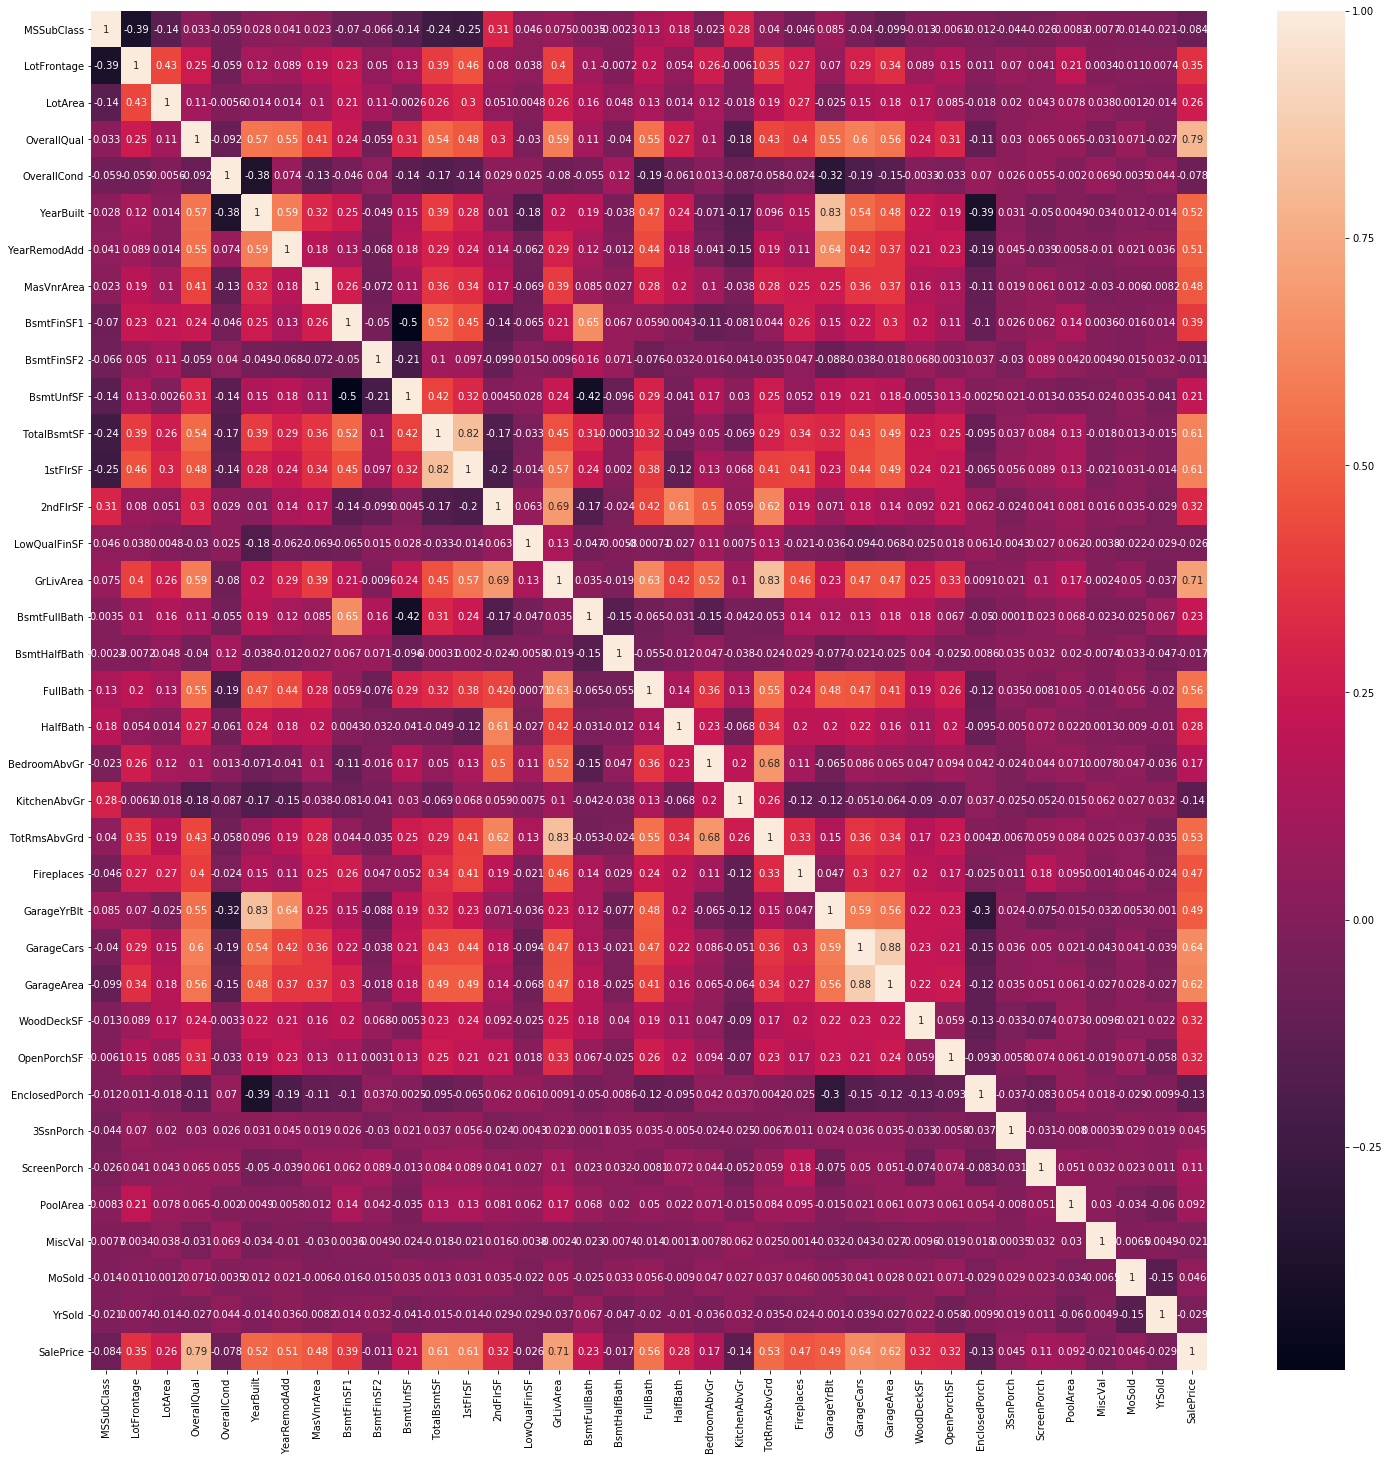

In [0]:
# cor-relation note that this includes only the numeric features
corr = train.corr()
colnames = corr.index
plt.figure(figsize=(25, 25))
g = sns.heatmap(data=corr, annot=True)

**Observations**
* I can see that the variables like `GrLivArea`, `OpenPorchSF`, `GarageArea` etc. have a strong positive co-relation with the `SalePrice`.
* On the contrary, there are also no variables that exibit a strong negative co-relation with the `SalePrice`
* Some variables, have a strong positive / negative co-relation with other variables (not the target variable). Eg. `GarageYrBuilt` and `YrBuilt`. This information can be used for dimentionality reduction, as having both the variables might not add more impact!

Extending above code to get variables with > `.5` and < -`.4` correlation

In [0]:
k = corr.unstack()
so = k.sort_values()
mask = ((so<-0.4) | (so > 0.5) & (so != 1))
colnames = so[mask].index
cols = []
for k in colnames:
    cols.append(k[0])
    cols.append(k[1])
cols = set(cols)
print (len(cols))

18


**So we have 18 highly co-related features!!, Let's plot a new heat map for them!!**

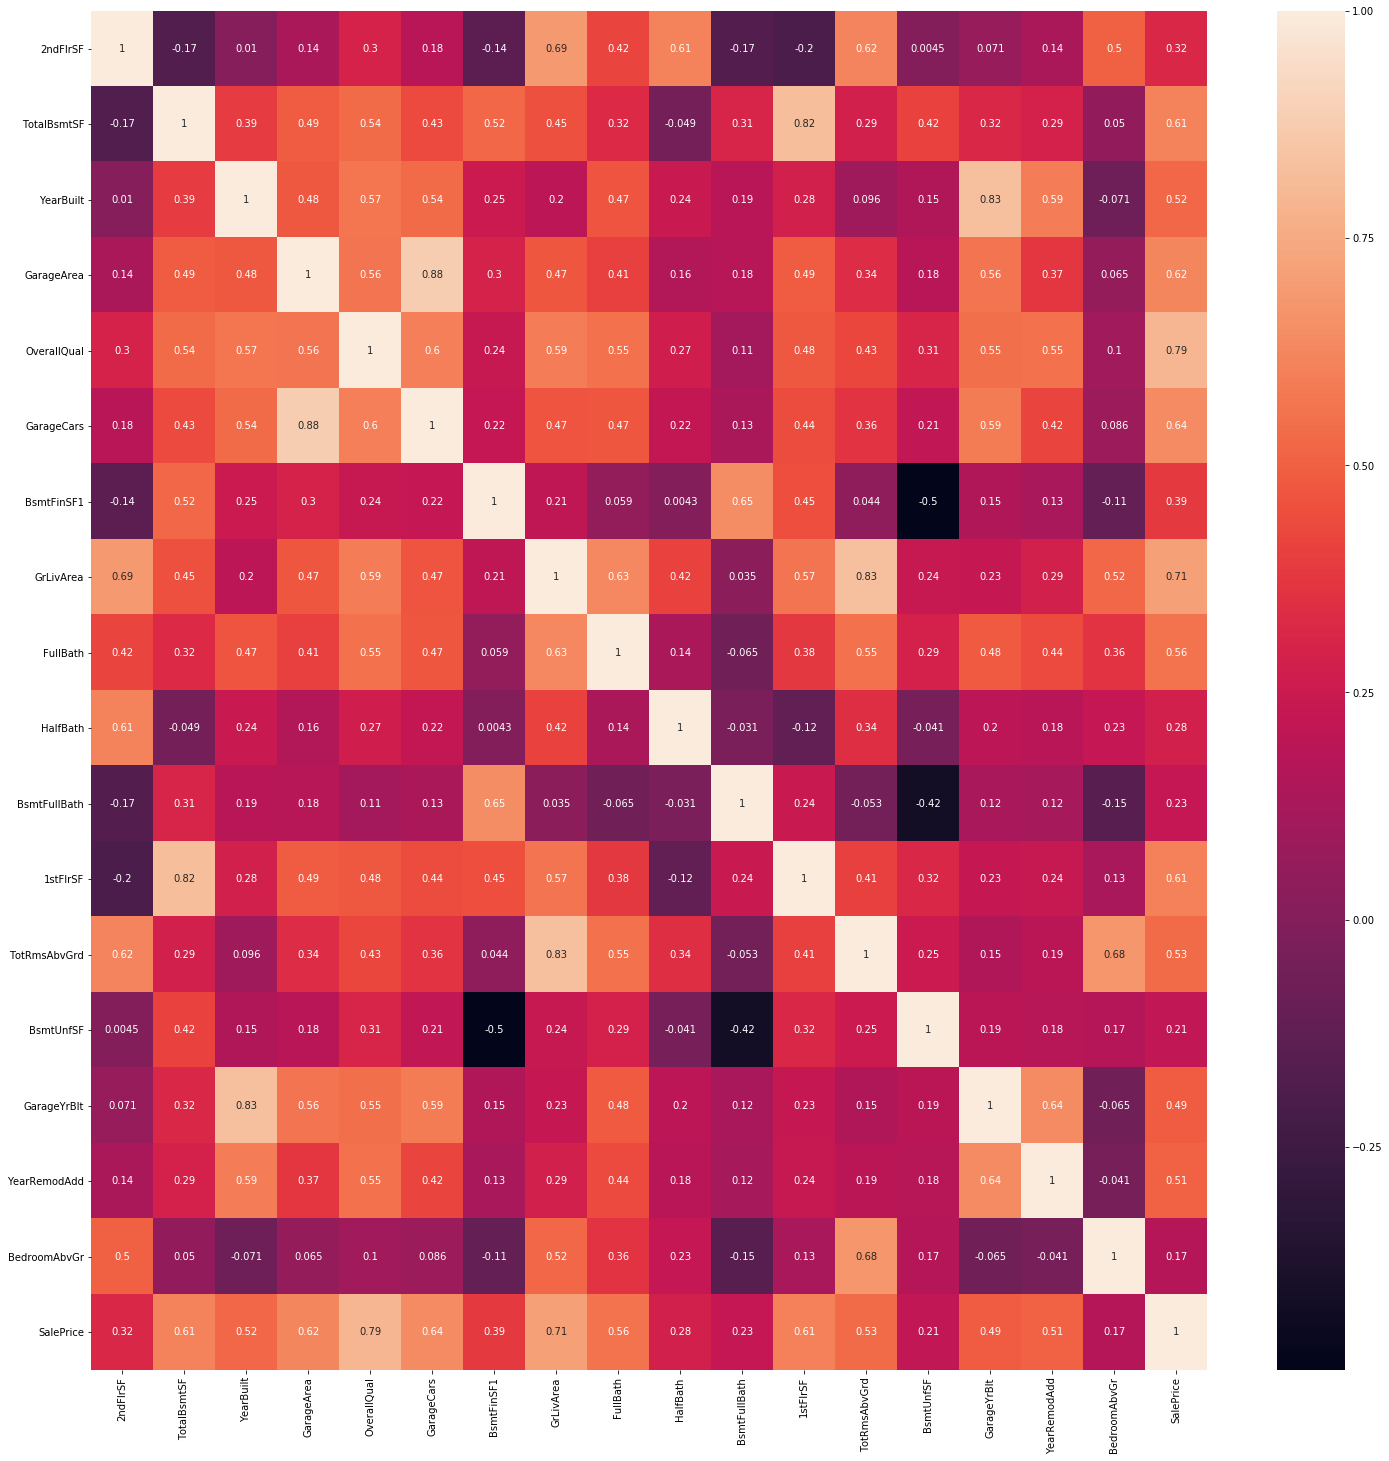

In [0]:
cols = list(cols)
cols.remove('SalePrice')
cols.append('SalePrice')
corr = train[cols].corr()
colnames = corr.index
plt.figure(figsize=(25, 25))
g = sns.heatmap(data=corr, annot=True)

### Data Processing

In [0]:
## Used later on for building regression models..
from sklearn.preprocessing import StandardScaler

def scale_data(train, test):
    cols = []
    for col in train.columns:
        print ("Scaling - "+col)
        if train[col].dtype != 'object' and col != 'SalePrice' and col != 'Id':
            cols.append(col)
    
    print ("Processing data")
    scaler = StandardScaler()
    scaler.fit(train[cols].values)
    train[cols] = scaler.transform(train[cols])
    test[cols] = scaler.transform(test[cols])
    return train, test
scaled_train, scaled_test = scale_data(train.copy(deep=True), test.copy(deep=True))

In [0]:
def get_one_hot_encoded(train, test, verbose=False):
    df = pd.concat([train.iloc[:, :-1], test], ignore_index=False)
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'Id':
            if verbose:
                print ("Processing "+col)
            df[col] = pd.Categorical(df[col])
            dummies = pd.get_dummies(df[col], prefix="cat_"+col)
            df = pd.concat([df, dummies], axis=1)
            df.drop(columns=[col], inplace=True)
    train = df.iloc[:train.shape[0],:]
    test = df.iloc[train.shape[0]:, :]
    return train, test

In [0]:
sc_enc_train, sc_enc_test = get_one_hot_encoded(scaled_train.copy(deep=True), 
                                                scaled_test.copy(deep=True))
sc_enc_train['SalePrice'] = train['SalePrice']

In [0]:
sc_enc_train.shape, sc_enc_test.shape

((1460, 289), (1459, 288))

In [0]:
nc_enc_train, nc_enc_test = get_one_hot_encoded(train.copy(deep=True), 
                                                test.copy(deep=True))
nc_enc_train['SalePrice'] = train['SalePrice']

In [0]:
nc_enc_train.shape, nc_enc_test.shape

((1460, 289), (1459, 288))

In [0]:
final_train, final_test = scale_data(train.copy(deep=True), test.copy(deep=True))
final_train, final_test = get_one_hot_encoded(final_train.copy(deep=True), final_test.copy(deep=True))
final_train['SalePrice'] = train['SalePrice']
print(final_train.shape, final_test.shape)

In [0]:
final_train = treat_null(final_train)
final_test = treat_null_test(final_train, final_test)

In [0]:
print(final_train.shape, final_test.shape)

(1460, 289) (1459, 288)


### Question 3

In [0]:
score_cols = cols
binary_vars = []
for col in nc_enc_train.columns:
    if (col in cols):
        print("Column "+col+" has "+str(nc_enc_train[col].unique().shape))
    if nc_enc_train[col].unique().shape[0] == 2:
        binary_vars.append(col)

Column OverallQual has (10,)
Column YearBuilt has (112,)
Column YearRemodAdd has (61,)
Column BsmtFinSF1 has (637,)
Column BsmtUnfSF has (780,)
Column TotalBsmtSF has (721,)
Column 1stFlrSF has (753,)
Column 2ndFlrSF has (417,)
Column GrLivArea has (861,)
Column BsmtFullBath has (4,)
Column FullBath has (4,)
Column HalfBath has (3,)
Column BedroomAbvGr has (8,)
Column TotRmsAbvGrd has (12,)
Column GarageYrBlt has (98,)
Column GarageCars has (5,)
Column GarageArea has (441,)
Column SalePrice has (663,)


In [0]:
score_cols.extend(binary_vars)
# Dedup 
score_cols = list(set(score_cols))
print(len(score_cols))

270


In [0]:
## Get the corr
score_corr = nc_enc_train.corr()
sale_price_col = score_corr['SalePrice']
sale_price_col.drop('SalePrice', axis=0, inplace=True)
display_all(sale_price_col.shape)

(288,)

In [0]:
top_related = sale_price_col[(sale_price_col>0.5) | (sale_price_col < -0.5)]

In [0]:
def get_score(row):
    score = row * top_related
    return np.sum(score)

In [0]:
nc_enc_train['Score'] = nc_enc_train.loc[:, top_related.index].apply(get_score, axis=1)

In [0]:
print(nc_enc_train['Score'].max())
print(nc_enc_train['Score'].min())

13559.731128375408
2447.8593925349264


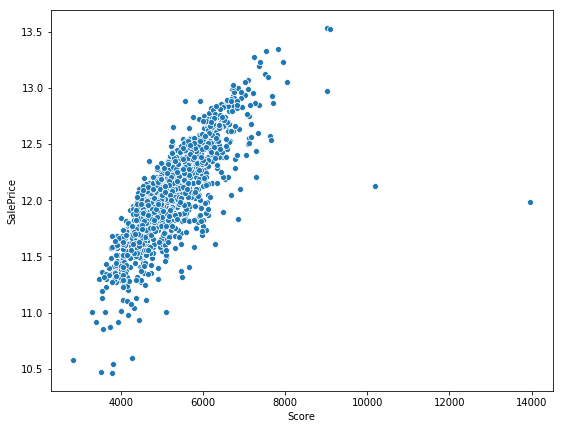

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.scatterplot(x=nc_enc_train['Score']+400, y=np.log(nc_enc_train['SalePrice']))

**Looks like a neat and clean positive co-relation between the score and the SalePrice**

### Top N best and worst desirable houses based on our scores

In [0]:
temp = train.loc[nc_enc_train.nlargest(3, 'Score').index]
temp['Score'] = nc_enc_train.nlargest(3, 'Score')['Score']
display_all(temp)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Score
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000,13559.731128
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750,9777.376253
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000,8683.285612


In [0]:
temp = train.loc[nc_enc_train.nsmallest(3, 'Score').index]
temp['Score'] = nc_enc_train.nsmallest(3, 'Score')['Score']
display_all(temp)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Score
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,Inside,Mod,BrkSide,Norm,Norm,1Fam,1Story,1,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,Fa,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,FuseF,334,0,0,334,0,0,1,0,1,1,Fa,2,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,39300,2447.859393
1101,30,RL,60.0,8400,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1Story,2,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,Fa,No,Rec,290,Unf,0,0,290,GasA,TA,N,FuseF,438,0,0,438,0,0,1,0,1,1,Fa,3,Typ,0,NaN,Detchd,1930.0,Unf,1,246,TA,TA,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2009,WD,Normal,60000,2903.648199
706,190,RM,70.0,5600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,2Story,4,5,1930,1950,Hip,CompShg,VinylSd,Wd Shng,None,0.0,Fa,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,SBrkr,372,720,0,1092,0,0,2,0,3,2,Fa,7,Mod,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,Othr,3500,7,2010,WD,Normal,55000,3005.254997


## *** Comments on the dream / desirable houses! ***
* It appears that the scoring function does a descent job in figuring out the most and least diserable houses to live in.
* Houses with the least scores have many things in common Eg. coincidently - cheap prices (I haven't included the `SalePrice` in computing the score have used only the co-relation of other variables to it), either a missing garrage type or detached, significantly lesser `LotArea`, too old built year i.e. `YearBuilt` I wouldn't like to live in a house that was built before WW2!!
* The best or the most desirable houses also have a lot of things in common, they mostly seem to be `2storey`, have significantly huge `LotArea`, realtively new build years etc. And above all, exorbitantly expensive. If I had a lot of money, I'd love to purchase one of them!!
* Some other observations - `GarageFinish`, `GarageFinish`, `PavedDrive`, `GarageCond` (Imp), `GarageArea`, `GarageType` (most important), `FireplaceQu`, `Fireplaces` (imp), `TotRmsAbvGrd`, `KitchenQual`, `HalfBath`, `FullBath`, `GrLivArea`, `2ndFlrSF`, `1stFlrSF`, `CentralAir`, `HeatingQC` etc. Excellent, desirable homes differ from the other for some of these variables.

### Question 2
Let's explore the highly co-related features that we got above!!

**1. An important Scatter Plot**

Text(0, 0.5, 'Log scale SalePrice')

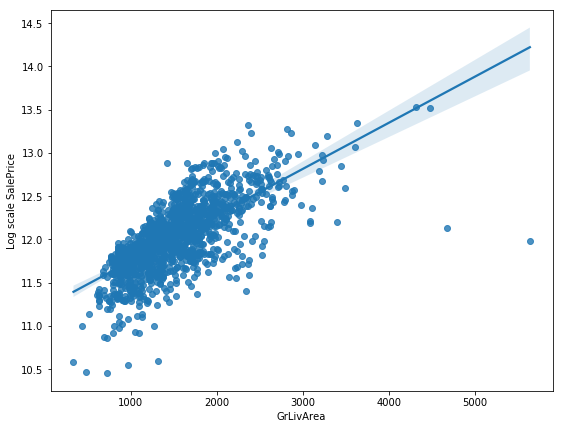

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.regplot(x=train['GrLivArea'], y=np.log(train['SalePrice']), truncate=True)
plt.ylabel("Log scale SalePrice")

**Wonderful, as per our observaton we have a 0.71 corr between these two variables, and the above plot validates our observation with a nice regression line!!**

**2. An important histogram / bar chart**  
Let's study the distribution of sale prices in our data set!!

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

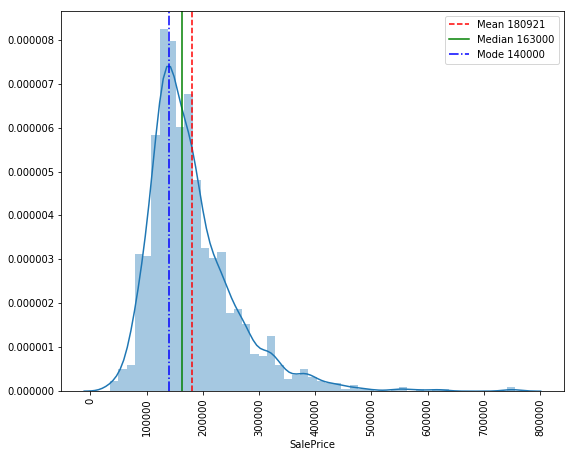

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

mean=train['SalePrice'].mean()
median=train['SalePrice'].median()
mode=train['SalePrice'].mode()[0]

g = sns.distplot(a=train['SalePrice'], kde=True, ax=ax)
ax.axvline(mean, color='r', linestyle='--')
ax.axvline(median, color='g', linestyle='-')
ax.axvline(mode, color='b', linestyle='-.')

plt.legend({'Mean '+str(int(mean)):mean,'Median '+str(int(median)):median,'Mode '+str(int(mode)):mode})
plt.setp(g.get_xticklabels(), rotation=90)

From the above diagram we can say that our distribution of the `SalePrice` is skewed. It can be quantified using the following metric called 'Kurtosis'. From the above graph, we can say that most houses are worth 140K and the mean value of houses is 180K.

In [0]:
print ('Kurtosis of the above distribution is - ' + str(train['SalePrice'].kurtosis()))

Kurtosis of the above distribution is - 6.536281860064529


**3. Line chart**

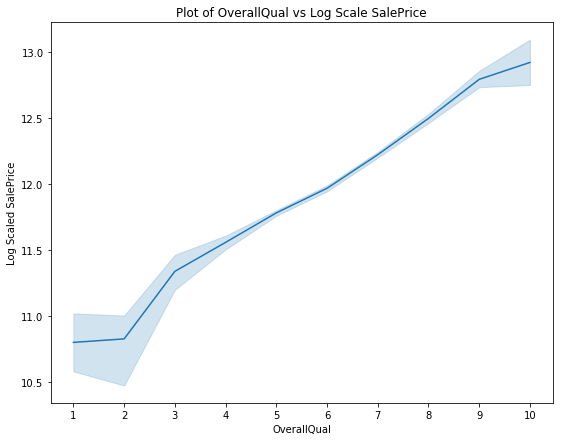

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.lineplot(x=train['OverallQual'], y=np.log(train['SalePrice']))
plt.title('Plot of OverallQual vs Log Scale SalePrice')
plt.xticks(np.arange(1,11))
plt.ylabel('Log Scaled SalePrice')
#plt.ayhspan(3, 11, color='red', alpha=0.2)
plt.show()

From the above line plot, we can infer that as `OverallQual` goes up, the Log scale of `SalePrice` increases. We can also say that, for lower and higer, the variance is also high but for middle prices, (like for `OverallQual` in (4, 8)) the variance is Log scale of `ScalePrice` is low!! So, it's going to be easy for our model to predict house prices if  `OverallQual` are between (4, 8), but hard if it's in the other ends!

**Other interesting Plots**

* `OverallQual` looks highly related to `SalePrice` let's explore!

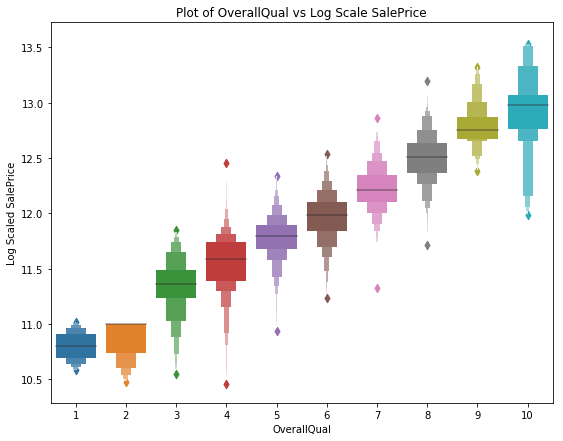

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.boxenplot(x=train['OverallQual'], y=np.log(train['SalePrice']))
plt.title('Plot of OverallQual vs Log Scale SalePrice')
plt.xticks(np.arange(0,10))
plt.ylabel('Log Scaled SalePrice')
#plt.ayhspan(3, 11, color='red', alpha=0.2)
plt.show()

From the above plot it's quite clear that with the increase in the `OverallQual` i.e. with expensive material, the cost distributions of the `SalePrice` generally grow up!!

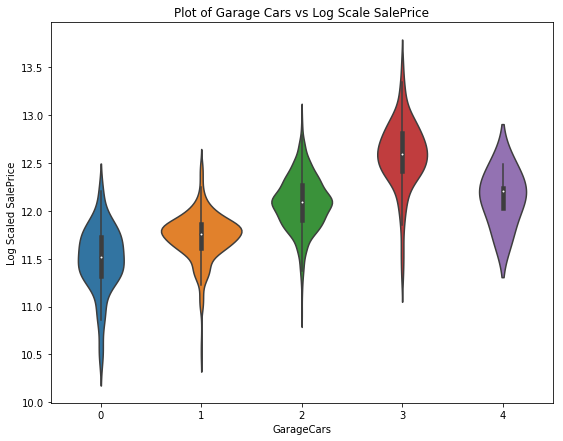

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.violinplot(x=train['GarageCars'], y=np.log(train['SalePrice']))
plt.title('Plot of Garage Cars vs Log Scale SalePrice')
plt.xticks(np.arange(0,5))
plt.ylabel('Log Scaled SalePrice')
#plt.ayhspan(3, 11, color='red', alpha=0.2)
plt.show()

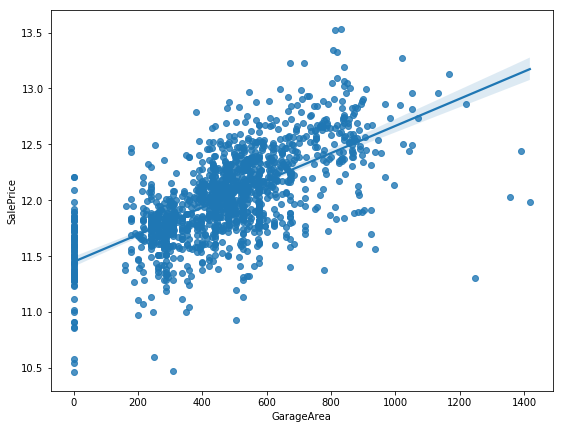

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.regplot(x=train['GarageArea'], y=np.log(train['SalePrice']), truncate=True)

**Nice Positive Co-relation again!!**

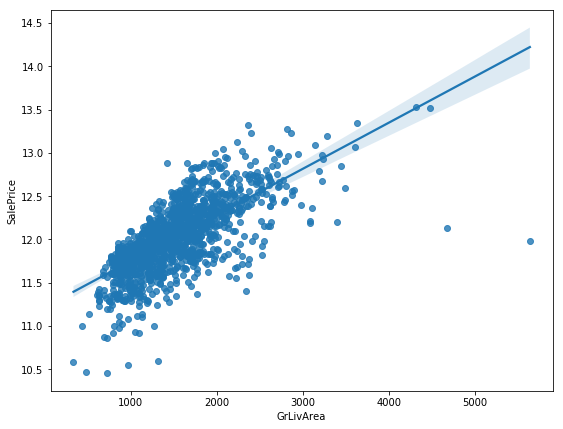

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.regplot(x=train['GrLivArea'], y=np.log(train['SalePrice']), truncate=True)

`GrLivArea` Yet another positive co-relation of course with some outliers!!

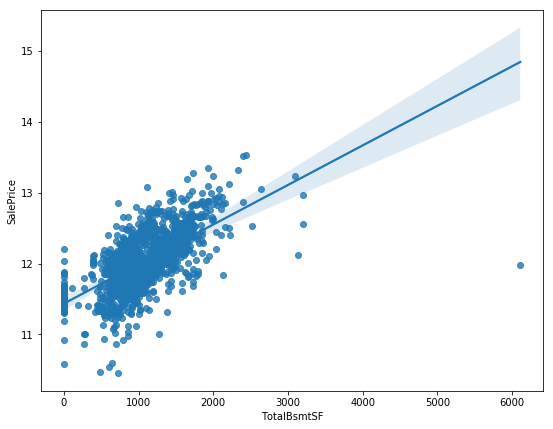

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.regplot(x=train['TotalBsmtSF'], y=np.log(train['SalePrice']), truncate=True)

`TotalBsmtSF` Yet another positive co-relation of course with some outliers!!

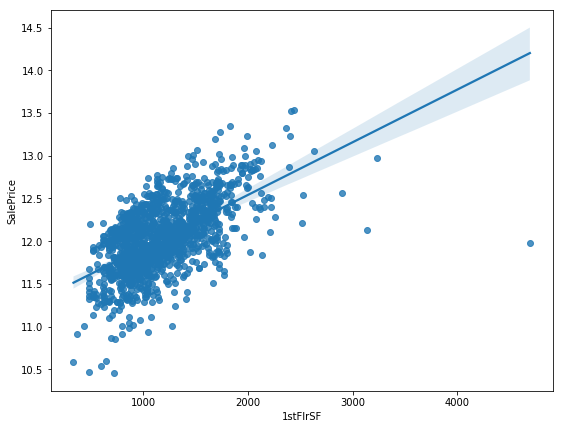

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.regplot(x=train['1stFlrSF'], y=np.log(train['SalePrice']), truncate=True)

`1stFlrSF` Yet another positive co-relation of course with some outliers!!

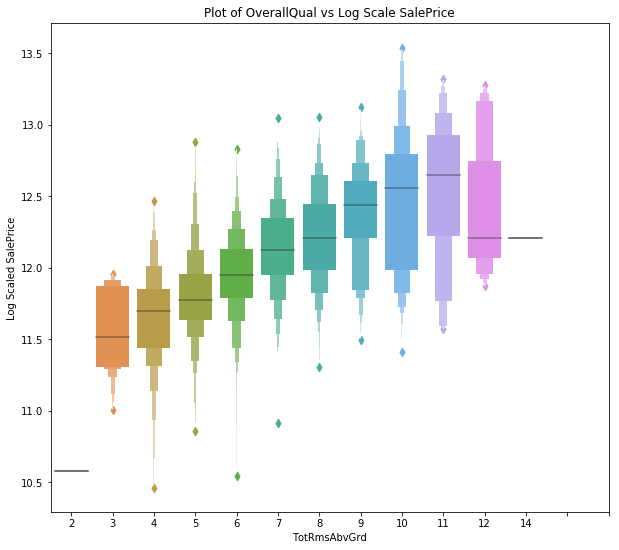

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 9)
sns.boxenplot(x=train['TotRmsAbvGrd'], y=np.log(train['SalePrice']))
plt.title('Plot of OverallQual vs Log Scale SalePrice')
plt.xticks(np.arange(0,14))
plt.ylabel('Log Scaled SalePrice')
#plt.ayhspan(3, 11, color='red', alpha=0.2)
plt.show()

Here, I find similar trend as that of `OverallQual`

### Question 6 
Simple Linear Regression Model  
![Imgur](https://i.imgur.com/ogV7jAe.png)

In [0]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_train.drop(columns=['SalePrice']), np.log(final_train['SalePrice']), test_size=0.95, random_state=9)

In [0]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
print (metrics.mean_squared_log_error(y_test, np.exp(model.predict(X_test))))

86.46091035285897


**Submit the Predictions!**

In [0]:
subms = pd.read_csv('My Drive/Colab Notebooks/sample_submission.csv')
subms['SalePrice'] = np.exp(model.predict(final_test))
subms.to_csv('My Drive/Colab Notebooks/Regression.csv')

The Model doesn't look impressive!

### Question 4

In [0]:
usc_train = treat_null(nc_enc_train)
unc_test = treat_null_test(nc_enc_train, nc_enc_test)

In [0]:
top_related = sale_price_col[(sale_price_col>0.3) | (sale_price_col < -0.3)]

In [0]:
from sklearn.metrics import pairwise_distances
dstX = pairwise_distances(usc_train[top_related.index], metric='euclidean')
dstF = pairwise_distances(final_train[top_related.index], metric='euclidean')

In [212]:
top_related.index

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'cat_Neighborhood_NoRidge',
       'cat_Neighborhood_NridgHt', 'cat_Exterior1st_VinylSd',
       'cat_Exterior2nd_VinylSd', 'cat_MasVnrType_None',
       'cat_MasVnrType_Stone', 'cat_ExterQual_Ex', 'cat_ExterQual_Gd',
       'cat_ExterQual_TA', 'cat_Foundation_CBlock', 'cat_Foundation_PConc',
       'cat_BsmtQual_Ex', 'cat_BsmtQual_TA', 'cat_BsmtExposure_Gd',
       'cat_BsmtFinType1_GLQ', 'cat_HeatingQC_Ex', 'cat_HeatingQC_TA',
       'cat_KitchenQual_Ex', 'cat_KitchenQual_Gd', 'cat_KitchenQual_TA',
       'cat_FireplaceQu_Gd', 'cat_GarageType_Attchd', 'cat_GarageType_Detchd',
       'cat_GarageFinish_Fin', 'cat_GarageFinish_Unf', 'cat_SaleType_New',
       'cat_SaleCondition_Partial'],
      dtype='object')

In [210]:
res0 = pd.concat([train.iloc[0,:], train.iloc[np.argmin(dstX[0,np.nonzero(dstX[0,:])]),:]], axis=1)
display_all(res0.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1366,60,FV,NaN,7500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0,Gd,TA,PConc,Gd,TA,No,GLQ,533,Unf,0,281,814,GasA,Ex,Y,SBrkr,814,860,0,1674,1,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2000,RFn,2,663,TA,TA,Y,0,96,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,Normal,216000


In [211]:
res1 = pd.concat([train.iloc[0,:], train.iloc[np.argmax(dstX[0,np.nonzero(dstX[0,:])]),:]], axis=1)
display_all(res1.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1298,180,RM,35,3675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SFoyer,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,82,TA,TA,PConc,Gd,TA,Gd,GLQ,547,Unf,0,0,547,GasA,Gd,Y,SBrkr,1072,0,0,1072,1,0,2,0,2,1,TA,5,Typ,0,NaN,Basment,2005,Fin,2,525,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000


In [213]:
res0 = pd.concat([train.iloc[0,:], train.iloc[np.argmin(dstF[0,np.nonzero(dstF[0,:])]),:]], axis=1)
display_all(res0.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1240,20,RL,64,9037,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,32,Gd,TA,PConc,Gd,TA,Av,GLQ,428,Unf,0,1048,1476,GasA,Ex,Y,SBrkr,1484,0,0,1484,0,0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2006,RFn,2,472,TA,TA,Y,120,33,0,0,0,0,NaN,NaN,NaN,0,12,2007,WD,Normal,265900


In [214]:
res1 = pd.concat([train.iloc[0,:], train.iloc[np.argmax(dstF[0,np.nonzero(dstF[0,:])]),:]], axis=1)
display_all(res1.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1298,180,RM,35,3675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SFoyer,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,82,TA,TA,PConc,Gd,TA,Gd,GLQ,547,Unf,0,0,547,GasA,Gd,Y,SBrkr,1072,0,0,1072,1,0,2,0,2,1,TA,5,Typ,0,NaN,Basment,2005,Fin,2,525,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000


#### Observations


1.   By throwing all the variables / highly co-related variables to the euclidean distance, doen't yeild satisfactory results. Even after scaling the data set.
2.   Therefore, to make it perform better, handpicking features, looks as key 
technique. So, in the following attempt, I handpick features and try to see if 
the Euclidean distance metric works for it!



In [0]:
dstX = pairwise_distances(usc_train[['YearBuilt','LotArea', '1stFlrSF','GrLivArea', 'GarageArea']], metric='euclidean')
dstF = pairwise_distances(final_train[['YearBuilt','LotArea', '1stFlrSF','GrLivArea', 'GarageArea']], metric='euclidean')

In [222]:
res0 = pd.concat([train.iloc[0,:], train.iloc[np.argmin(dstF[0,np.nonzero(dstF[0,:])]),:]], axis=1)
display_all(res0.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1265,120,RH,34,4060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,TwnhsE,1Story,6,5,1998,1999,Gable,CompShg,MetalSd,MetalSd,None,0,Gd,TA,PConc,Gd,TA,No,GLQ,266,Unf,0,1139,1405,GasA,Ex,Y,SBrkr,1337,0,0,1337,1,0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1998,Fin,2,511,TA,TA,Y,144,68,0,0,0,0,NaN,NaN,NaN,0,8,2008,COD,Abnorml,181000


In [223]:
res1 = pd.concat([train.iloc[0,:], train.iloc[np.argmax(dstF[0,np.nonzero(dstF[0,:])]),:]], axis=1)
display_all(res1.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
692,60,RL,104,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000




1.   After providing, hand-picked features, the Euclidean distance manages to perform an 'Ok' job in optimizing the differences between the values of those two values for the given house pairs only!
2.   Overall, it's not that effective!!



In [0]:
dstF = pairwise_distances(usc_train[['YearBuilt']], metric='l2')

In [303]:
res1 = pd.concat([train.iloc[0,:], train.iloc[np.argmin(dstF[0,np.nonzero(dstF[0,:])]),:]], axis=1)
display_all(res1.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
6,50,RL,85,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000


In [301]:
res1 = pd.concat([train.iloc[0,:], train.iloc[np.argmax(dstF[0,:]),:]], axis=1)
display_all(res1.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1350,70,RM,50,5250,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,8,5,1872,1987,Gable,CompShg,MetalSd,MetalSd,None,0,TA,Gd,BrkTil,TA,Fa,No,LwQ,259,Unf,0,425,684,OthW,Fa,N,SBrkr,938,1215,205,2358,0,0,2,0,4,1,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,54,20,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,122000


In [0]:
dstF = pairwise_distances(usc_train[['YearBuilt']], metric='l1')

In [323]:
res1 = pd.concat([train.iloc[0,:], train.iloc[np.argmin(dstF[np.nonzero(dstF[0,:])]),:]], axis=1)
display_all(res1.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [319]:
res1 = pd.concat([train.iloc[0,:], train.iloc[np.argmax(dstF[0,:]),:]], axis=1)
display_all(res1.T)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1350,70,RM,50,5250,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,8,5,1872,1987,Gable,CompShg,MetalSd,MetalSd,None,0,TA,Gd,BrkTil,TA,Fa,No,LwQ,259,Unf,0,425,684,OthW,Fa,N,SBrkr,938,1215,205,2358,0,0,2,0,4,1,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,54,20,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,122000


In [322]:
np.amin(dstF[0, np.nonzero()])

0.0

In [0]:
tmp = pd.DataFrame()
tmp['a'] = np.random.randint(1, 10, 5)
tmp['b'] = np.random.randint(1, 10, 5)

In [0]:
dst = pairwise_distances(tmp, tmp, metric='l2')

In [337]:
dst

array([[0.        , 5.38516481, 5.        , 4.12310563, 2.        ],
       [5.38516481, 0.        , 1.41421356, 3.16227766, 5.        ],
       [5.        , 1.41421356, 0.        , 4.        , 4.12310563],
       [4.12310563, 3.16227766, 4.        , 0.        , 5.        ],
       [2.        , 5.        , 4.12310563, 5.        , 0.        ]])

In [346]:
#np.argmin(dst[0, [1,2,3,4]], axis=1)
#np.nonzero(dst[0,:])
#res1 = pd.concat([tmp.iloc[0,:], tmp.iloc[np.argmin(dstF[np.nonzero(dstF[0,:])]),:]], axis=1)
#display_all(res1)
np.argmin(dst[0, [1,2,3,4]])

3

In [310]:
np.argmin (dstF [0, np.nonzero (dstF [0,:])], axis=)

array([0, 0, 0, ..., 0, 0, 0])

In [312]:
dstF[0,1:10]

array([27.,  2., 88.,  3., 10.,  1., 30., 72., 64.])

In [265]:
res1 = pd.concat([train.iloc[0,:], train.iloc[np.argmax(dstF[0,:]], axis=0)
display_all(res1.T)

MSSubClass            60
MSZoning              RL
LotFrontage           65
LotArea             8450
Street              Pave
Alley                NaN
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood     CollgCr
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        2Story
OverallQual            7
OverallCond            5
YearBuilt           2003
YearRemodAdd        2003
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType       BrkFace
MasVnrArea           196
ExterQual             Gd
ExterCond             TA
Foundation         PConc
BsmtQual              Gd
BsmtCond              TA
BsmtExposure          No
BsmtFinType1         GLQ
BsmtFinSF1           706
BsmtFinType2         Unf
BsmtFinSF2             0
BsmtUnfSF            150
TotalBsmtSF          856
Heating             GasA
HeatingQC             Ex


In [263]:
dstF

array([[ 0., 27.,  2., ..., 62., 53., 38.],
       [27.,  0., 25., ..., 35., 26., 11.],
       [ 2., 25.,  0., ..., 60., 51., 36.],
       ...,
       [62., 35., 60., ...,  0.,  9., 24.],
       [53., 26., 51., ...,  9.,  0., 15.],
       [38., 11., 36., ..., 24., 15.,  0.]])

In [264]:
np.argmax(dstF[0,:], axis=0)

1349

In [0]:
dstF = pairwise_distances(usc_train[['YearBuilt']], metric='l2')

In [262]:
dstF.argmin(axis=0)

array([  0,   1,   2, ..., 170,  90,  10])

In [260]:
display_all(pd.Series(dstF[0,:]))

0         0.0
1        27.0
2         2.0
3        88.0
4         3.0
5        10.0
6         1.0
7        30.0
8        72.0
9        64.0
10       38.0
11        2.0
12       41.0
13        3.0
14       43.0
15       74.0
16       33.0
17       36.0
18        1.0
19       45.0
20        2.0
21       73.0
22        1.0
23       27.0
24       35.0
25        4.0
26       52.0
27        4.0
28       46.0
29       76.0
30       83.0
31       37.0
32        4.0
33       44.0
34        2.0
35        1.0
36        9.0
37       49.0
38       50.0
39       48.0
40       38.0
41       44.0
42       20.0
43       28.0
44       44.0
45        2.0
46        0.0
47        3.0
48       83.0
49       37.0
50        6.0
51       69.0
52       40.0
53       22.0
54       48.0
55       39.0
56        4.0
57        1.0
58        3.0
59       31.0
60        1.0
61       83.0
62        3.0
63       82.0
64        6.0
65        1.0
66       33.0
67        0.0
68       58.0
69       50.0
70       30.0
71    

In [0]:
a = np.arange(6).reshape(2,3) + 10

In [258]:
train.iloc[np.argmin(dstF[0,np.nonzero(dstF[0,:])]),:]

MSSubClass            50
MSZoning              RL
LotFrontage           85
LotArea            14115
Street              Pave
Alley                NaN
LotShape             IR1
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood     Mitchel
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        1.5Fin
OverallQual            5
OverallCond            5
YearBuilt           1993
YearRemodAdd        1995
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType          None
MasVnrArea             0
ExterQual             TA
ExterCond             TA
Foundation          Wood
BsmtQual              Gd
                  ...   
BedroomAbvGr           1
KitchenAbvGr           1
KitchenQual           TA
TotRmsAbvGrd           5
Functional           Typ
Fireplaces             0
FireplaceQu          NaN
GarageType        Attchd
GarageYrBlt         1993


### Question Clustering

In [0]:
top_related.index.shape

(26,)